In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/6888/project/tomatoAll.zip /content
!unzip /content/tomatoAll.zip

Streaming output truncated to the last 5000 lines.
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/253ddc99-8132-4710-bb89-eb83ab271abc___Matt.S_CG 0698.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25592188-309d-450c-b45f-fbbdb02b316f___Matt.S_CG 6181.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/2567c820-aa63-490c-8e47-921b85164728___Matt.S_CG 7447.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/256b92d9-41f3-47a4-870f-c0c0f0ac201e___Matt.S_CG 6842.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25b6cc2a-d883-4e3f-9caa-738e5ec35e30___JR_Sept.L.S 8465.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25c45a05-4f45-42ad-b18a-b7f694023a31___Matt.S_CG 0824.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25f7a39f-7fef-4f5d-af4f-cf21934f516a___JR_Sept.L.S 2493.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/261666dc-32fb-43b2-93

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



base_path = '/content/tomatoAll/'
expert_path = '/content/tomatoAll/plan-diseases-expert'
village_path = '/content/tomatoAll/plant-village'


BATCH_SIZE = 128
IMG_SIZE = (256, 256)
SEED = 42

In [8]:
train_gen, test_gen = tf.keras.utils.image_dataset_from_directory(
    expert_path,
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


VALIDATION_SPLIT = 0.15

train_gen = train_gen.take(int((1 - VALIDATION_SPLIT) * len(train_gen)))
valid_gen = train_gen.skip(int((1 - VALIDATION_SPLIT) * len(train_gen)))

test2_gen = tf.keras.utils.image_dataset_from_directory(
    village_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# use cache to improve speed
train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_gen = valid_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_gen = test_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test2_gen = test2_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 37455 files belonging to 9 classes.
Using 31837 files for training.
Using 5618 files for validation.
Found 12803 files belonging to 9 classes.


In [4]:
from tensorflow.keras.applications import ResNet101, InceptionV3, EfficientNetB1
from tensorflow.keras.applications import DenseNet121, DenseNet201, DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
import time
import matplotlib.pyplot as plt

In [5]:

def create_and_train_model(base_model, train_gen, test_gen, freeze_layers=True):

    # Freeze layers
    if freeze_layers:
      for layer in base_model.layers:
          layer.trainable = False

    # Add Flatten layer
    # x = Flatten()(base_model.output)

    # Add GlobalAveragePooling2D layer
    x = GlobalAveragePooling2D()(base_model.output)

    # Modify pre-trained model
    output = Dense(9, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model for 50 epochs
    history = model.fit(train_gen, validation_data=valid_gen, epochs=50)


    # Plotting Loss
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Measure inference time
    start_time = time.time()
    _, accuracy = model.evaluate(test_gen)
    end_time = time.time()
    inference_time = end_time - start_time

    # Measure inference time 2
    start_time = time.time()
    _, accuracy2 = model.evaluate(test2_gen)
    end_time = time.time()
    inference_time2 = end_time - start_time

    # Get model size (number of parameters)
    num_params = model.count_params()

    return num_params, inference_time, accuracy, inference_time2, accuracy2

51877672/51877672 [==============================] - 0s 0us/step
Epoch 1/50
13/13 [==============================] - 118s 1s/step - loss: 0.6055 - accuracy: 0.8042 - val_loss: 16.0991 - val_accuracy: 0.1587
Epoch 2/50
13/13 [==============================] - 7s 566ms/step - loss: 0.0460 - accuracy: 0.9849 - val_loss: 20.2340 - val_accuracy: 0.1892
Epoch 3/50
13/13 [==============================] - 7s 566ms/step - loss: 0.0097 - accuracy: 0.9976 - val_loss: 13.7179 - val_accuracy: 0.2471
Epoch 4/50
13/13 [==============================] - 7s 566ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 10.4946 - val_accuracy: 0.2280
Epoch 5/50
13/13 [==============================] - 7s 565ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 6.4944 - val_accuracy: 0.3250
Epoch 6/50
13/13 [==============================] - 7s 565ms/step - loss: 3.6473e-04 - accuracy: 1.0000 - val_loss: 3.0877 - val_accuracy: 0.5334
Epoch 7/50
13/13 [==============================] - 7s 566ms/step - loss: 7.

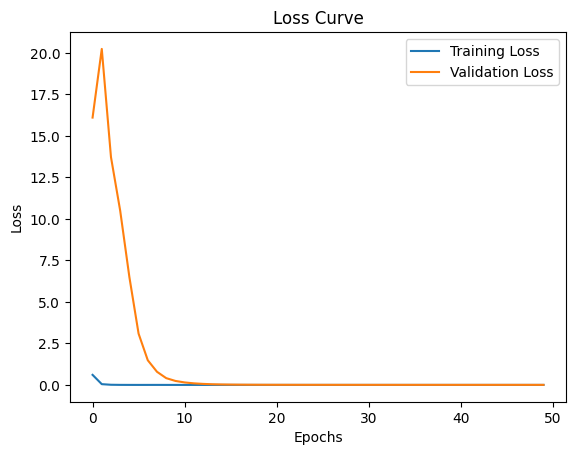

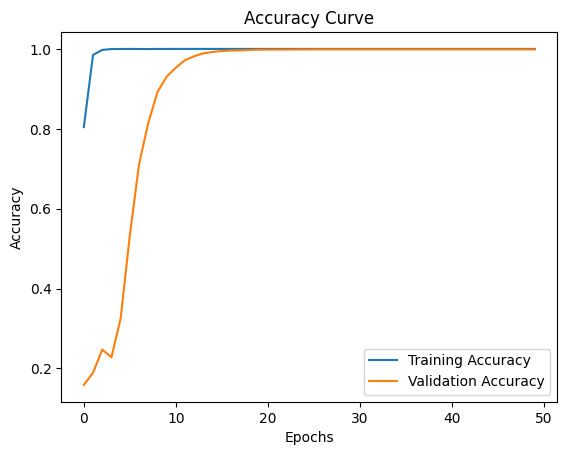

7/7 [==============================] - 2s 169ms/step - loss: 0.0073 - accuracy: 0.9981
DenseNet169: Params=12657865, Time=1.1801395416259766, Accuracy=0.9930580258369446, Time2=2.310380220413208, Accuracy2=0.998125433921814


In [6]:
# Create and train DenseNet169 75 2048
densenet_base = DenseNet169(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, freeze_layers=False)
print(f"DenseNet169: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")

Epoch 1/50
211/211 [==============================] - 184s 437ms/step - loss: 0.1398 - accuracy: 0.9547 - val_loss: 3.3137 - val_accuracy: 0.5454
Epoch 2/50
211/211 [==============================] - 86s 407ms/step - loss: 0.0388 - accuracy: 0.9868 - val_loss: 0.2855 - val_accuracy: 0.9097
Epoch 3/50
211/211 [==============================] - 86s 407ms/step - loss: 0.0120 - accuracy: 0.9962 - val_loss: 0.0614 - val_accuracy: 0.9773
Epoch 4/50
211/211 [==============================] - 86s 407ms/step - loss: 0.0244 - accuracy: 0.9924 - val_loss: 0.2272 - val_accuracy: 0.9346
Epoch 5/50
211/211 [==============================] - 86s 407ms/step - loss: 0.0267 - accuracy: 0.9910 - val_loss: 0.3255 - val_accuracy: 0.9165
Epoch 6/50
211/211 [==============================] - 86s 407ms/step - loss: 0.0119 - accuracy: 0.9963 - val_loss: 0.7805 - val_accuracy: 0.8159
Epoch 7/50
211/211 [==============================] - 86s 407ms/step - loss: 0.0030 - accuracy: 0.9991 - val_loss: 0.0214 - val_a

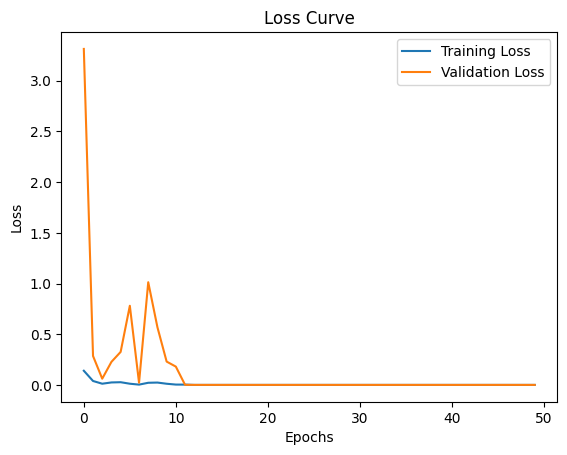

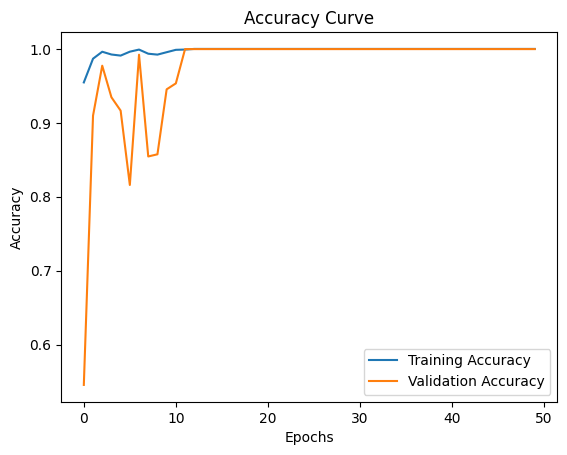

101/101 [==============================] - 14s 137ms/step - loss: 2.3888e-04 - accuracy: 0.9998
DenseNet169: Params=12657865, Time=6.292489051818848, Accuracy=0.9998220205307007, Time2=14.06806206703186, Accuracy2=0.9998437762260437


In [9]:
# Create and train DenseNet169 256 128
densenet_base = DenseNet169(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
densenet_params, densenet_time, densenet_acc, densenet_time2, densenet_acc2 = create_and_train_model(densenet_base, train_gen, test_gen, freeze_layers=False)
print(f"DenseNet169: Params={densenet_params}, Time={densenet_time}, Accuracy={densenet_acc}, Time2={densenet_time2}, Accuracy2={densenet_acc2}")